# One-class Classification : Isolation Forest (iForest)

In [19]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
from tqdm import tqdm
import time

In [20]:
#Default hyperparameters#
N_TREES=100
HEIGHT_LIMIT=10
#########################

### Isolation Forest Classification : Algorithm

In [21]:
np.random.seed(0)

def normalizer(size):
    if size == 2:
        return 1
    elif size > 2:
        return 2 * (np.log(size - 1) + 0.5772156649) - 2 * (size - 1) / size
    return 0


class IsolationTree:

    def __init__(self, height_limit, current_height=0):
        self.height_limit = height_limit
        self.current_height = current_height
        self.split_by = None
        self.split_value = None
        self.left = None
        self.right = None
    
    def fit(self, X):
        if self.current_height >= self.height_limit or X.shape[0] <= 1:
            return self
        n_samples, n_features = X.shape
        self.split_by = np.random.choice(n_features)
        self.split_value = np.random.uniform(X[:, self.split_by].min(), X[:, self.split_by].max())
        left = X[X[:, self.split_by] < self.split_value]
        right = X[X[:, self.split_by] >= self.split_value]
        # print(left.shape, right.shape, X.shape, self.current_height, self.height_limit)
        self.left = IsolationTree(self.height_limit, self.current_height + 1).fit(left)
        self.right = IsolationTree(self.height_limit, self.current_height + 1).fit(right)
        return self

    def predict(self, X):
        if self.current_height >= self.height_limit:
            return np.ones(X.shape[0])
        return (X[:, self.split_by] < self.split_value) * self.left.predict(X) + (X[:, self.split_by] >= self.split_value) * self.right.predict(X)
    
    def path_length(self, X, current_height=0):
        if self.current_height >= self.height_limit or X.shape[0] <= 1 or self.split_value is None:
            return np.full(X.shape[0], current_height)
        ans = np.zeros(X.shape[0])
        ans[X[:, self.split_by] < self.split_value] = self.left.path_length(X[X[:, self.split_by] < self.split_value], current_height + 1)
        ans[X[:, self.split_by] >= self.split_value] = self.right.path_length(X[X[:, self.split_by] >= self.split_value], current_height + 1)
        return ans


class IsolationForest:

    def __init__(self, n_trees=N_TREES, height_limit=HEIGHT_LIMIT):
        self.n_trees = n_trees
        self.height_limit = height_limit
        self.trees = []

    def fit(self, X):
        self.len = X.shape[0]
        self.trees = [IsolationTree(self.height_limit).fit(X) for _ in tqdm(range(self.n_trees), desc='Fitting Trees')]
        return self
    
    def predict(self, X):
        return np.mean([tree.predict(X) for tree in self.trees], axis=0)
    
    def path_length(self, X, desc='Calculating Path Length'):
        return np.mean([tree.path_length(X) for tree in tqdm(self.trees, desc=desc)], axis=0)
    
    def anomaly_score(self, X, desc):
        return 2 ** (-self.path_length(X, desc) / normalizer(self.len))

### Evaluation function

In [22]:
def evaluate(csv_file_path,ycolname):
    df = pd.read_csv(csv_file_path)
    time_start = time.time()   
    trainx, testx, trainy, testy = train_test_split(df.drop([ycolname], axis=1).values, df[ycolname].values, test_size=0.2,random_state=42)
    iforest = IsolationForest(n_trees=N_TREES, height_limit=HEIGHT_LIMIT).fit(trainx[trainy==0])
    anomaly_train = iforest.anomaly_score(trainx, desc='Calculating Training Path Length')
    anomaly_in = anomaly_train[trainy==0]
    anomaly_out = anomaly_train[trainy>0]
    print("Train Inlier anomaly score:",np.mean(anomaly_in))
    print("Train Outlier anomaly score:",np.mean(anomaly_out))
    anomaly_test = iforest.anomaly_score(testx, desc='Calculating Test Path Length')
    testy_pred = np.where(anomaly_test > (np.mean(anomaly_in)+np.mean(anomaly_out))/2, 1, 0)
    #show confusion matrix to check directional accuracy
    cm = confusion_matrix(testy>0, testy_pred>0)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Inlier','Outlier'])
    disp.plot()
    print("\nOutlier predictions:",np.sum(testy_pred>0))
    print("Inlier predictions:",np.sum(testy_pred<=0))
    print("Outlier actuals:",np.sum(testy>0))
    print("Inlier actuals:",np.sum(testy<=0))
    print(f'Accuracy score: {accuracy_score(testy>0, testy_pred>0) :>.3%}')
    print(f'Precision score: {precision_score(testy>0, testy_pred>0) :>.3%}')
    print(f'Recall score: {recall_score(testy>0, testy_pred>0) :>.3%}')
    print(f'F1 score: {f1_score(testy>0, testy_pred>0) :>.3%}')
    time_end = time.time()
    print("Time taken:",time_end-time_start)
    plt.show()

### Evaluation on Dataset 1 : 'http.csv'

Calculating Training Path Length: 100%|██████████| 100/100 [00:13<00:00,  7.51it/s]


Train Inlier anomaly score: 0.7595183415886935
Train Outlier anomaly score: 0.7867716531035541


Calculating Test Path Length: 100%|██████████| 100/100 [00:03<00:00, 27.51it/s]



Outlier predictions: 462
Inlier predictions: 113038
Outlier actuals: 445
Inlier actuals: 113055
Accuracy score: 99.981%
Precision score: 95.887%
Recall score: 99.551%
F1 score: 97.685%
Time taken: 27.940002918243408


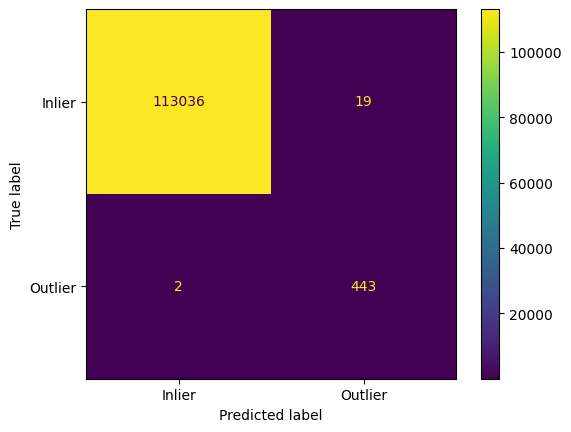

In [23]:
#Application-specific hyperparameters#
N_TREES=100
HEIGHT_LIMIT=10
######################################

evaluate('http.csv','attack')

### Evaluation on Dataset 2 : 'cancer.csv'

Fitting Trees:   0%|          | 0/100 [00:00<?, ?it/s]

Calculating Training Path Length: 100%|██████████| 100/100 [00:00<00:00, 629.79it/s]


Train Inlier anomaly score: 0.534812247655082
Train Outlier anomaly score: 0.6315572819142257


Calculating Test Path Length: 100%|██████████| 100/100 [00:00<00:00, 1178.73it/s]



Outlier predictions: 44
Inlier predictions: 70
Outlier actuals: 43
Inlier actuals: 71
Accuracy score: 90.351%
Precision score: 86.364%
Recall score: 88.372%
F1 score: 87.356%
Time taken: 0.635157585144043


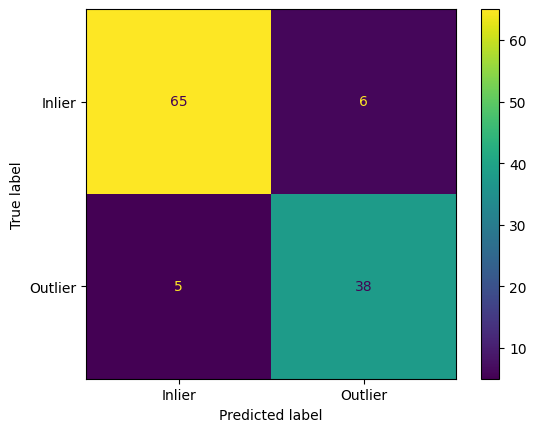

In [24]:
#Application-specific hyperparameters#
N_TREES=100
HEIGHT_LIMIT=10
######################################

evaluate('cancer.csv','diagnosis')